## Classifying 10 Monkey Species
This notebook includes a simple demo about how to use Tensorflow, wraped in the Keras API, to fine-tune a pre-trained DNN on a really small dataset for monkey species.

### Dataset
The dataset we used in this example has been made available in [Kaggle](https://www.kaggle.com/slothkong/10-monkey-species). Note that images in the dataset have different sizes, so we run a simple bash script (resizer.h) to resize them to 256x256 px.

### Transfer Learning & Dataset Augmentation
Since our dataset has very limited amount of samples per class (about 100 images), and there is a significant amount of similarities between species, this example provides a good chance to check the benefits of transfer learing techniques. Also, data augmentation might help us to make the must out of the few images we have. 

We  will use a pre-trained model from [Keras](https://keras.io/applications/) repository, VGG-16 to be precise. We chose VGG-16 simply becuase its a bit more familiar to the community, but we could have used residual nets  or NiN (Network in Network) architectures as well.  

![alt text](vgg16.png "VGG-16")

The [ImageDataGenerator](https://keras.io/preprocessing/image/) module of Keras covers must of the basic data augmentation tricks, so we will be using it in this example.

Let us begin...

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

# --- import Keras modules ---
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input as zero_mean
from keras.layers import Dense, Activation, Flatten , merge, Input
from keras.models import Model

# --- import a pre-trained model & utility functions ---
from vgg16 import VGG16 # Available at https://github.com/fchollet/deep-learning-models
from my_utilities import predictions_decoder, confusion_matrix_plotter, plotter # auxiliary custom functions for evaluation

Using TensorFlow backend.


In [2]:
# specify the dataset folder path
# for clarity, training and validation images are split into different directories
TRAIN_DIR = '../dataset_monkeys/training'
VAL_DIR = '../dataset_monkeys/validation'

# --- data related parameters ---
img_width = 224 # determined by the pre-trained model
img_height = 224 # determined by the pre-trained model
batch_size = 32 # we could try other values if we were concerned about the training speed
train_dataset_size = 1098
val_dataset_size = 272
number_classes = 10 # the dataset contains 10 different species

# --- training related parameters ---
steps_per_epoch = round(float(train_dataset_size)/batch_size,0) # evaluates to 34
validation_steps = round(float(val_dataset_size)/batch_size,0) # evaluates to 9
number_epochs = 50 # we will train for 50 epochs

Due to the low number of samples, we use data augmentation to introduce variations into the data. Keras provides a built-in module, ImageDataGenerator, that allows us to perform rotations, shifting, shearing, fliping and zooming operations on the images...

In [3]:
# images will be read from the previously defined directories 
# converted to numpy arrays, pre-processed (augmented and normalized),
# and batched before we feed it to the training method

# --- training data generator ---
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',preprocessing_function = zero_mean)

train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    seed = 2)

# --- validation data generator ---
val_datagen = ImageDataGenerator() # no augmentation is used on validation data

val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False)

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


...lets take random image and examine how the augmented images will look like 

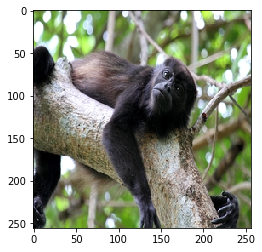

In [4]:
LABEL = 'n0'
IMAGE = 'n0021.jpg'
img = load_img(TRAIN_DIR+'/'+LABEL+'/'+IMAGE) # image loaded as PIL object
_ = plt.imshow(img)

After pre-processing the image we obtain the following variations 

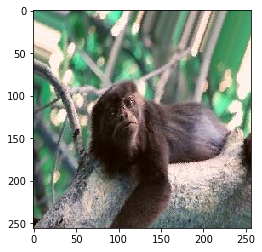

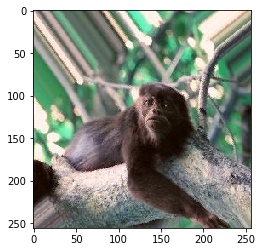

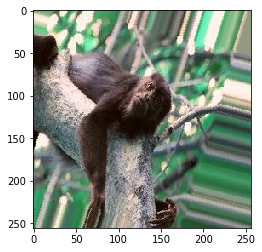

In [5]:
x = img_to_array(img)  # convert the image to numpy array of shape (3, 256, 256)
x = x.reshape((1,) + x.shape)  # reshape to (1, 3, 256, 256). The order in which we reorder the 
                               # tensor dimensions is selected according to TF requirements 

SAVE_DIR = 'preview' # a sample directory to store the augmented images

i = 0
for batch in train_datagen.flow(x,batch_size=1, save_to_dir=SAVE_DIR,save_format='jpg'):
    # flow() generates batches of randomly transformed images 
    # and saves them to the specified directory
    i += 1
    if i>2: break  # prevent the generator from looping indefinitely
        
IMG_PATHS = os.listdir(SAVE_DIR)
for PATH in IMG_PATHS:
    img = load_img(SAVE_DIR+'/'+PATH)
    plt.figure()
    _ = plt.imshow(img)   

Alrigth, now lets's build the model, making sure to replace only the last fully-connected layer (the classifier). The last layer will no longer represent 1000 classes, now only 10

In [6]:
placeholder = Input(shape=(224, 224, 3)) # input layer to the model (Keras API requirement)
model = VGG16(input_tensor=placeholder, # load the pretrained model
              include_top=True,         # the VGG16 script will automatically download the
              weights='imagenet')       # weigths if they are stored not locally

And select the second to last fc layer to use it as base for the new classifier layer. Next we should freeze all weights of the model except for the ones of the new layer, since the frozen weights have already been trained to identify features in imagenet samples.

In [7]:
last_layer = model.get_layer('fc2').output
classifier = Dense(units=10, activation='softmax',name='output')(last_layer)

costum_model = Model( placeholder, classifier) # instantiate a Model object with the correspoding inputs and structure

for layer in costum_model.layers[:-1]: # fix weights from all but the new layer
    layer.trainable = False

In [8]:
costum_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adadelta',
    metrics=['accuracy'])

# print the details of the costume made model
costum_model.summary() 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Observe that only a partial number of parameters (40,970) can be trained. We imposed this restriction, of course.
Haven built the desired model with the necessary number of weights marked as untrainable, we are ready to fine-tune it.

In [9]:
t = time.time() # set the timer

# create a variable (hist)  to store the output information of the training process
hist = costum_model.fit_generator(
    generator = train_data,
    steps_per_epoch = steps_per_epoch,
    epochs = number_epochs,
    validation_data = val_data,
    validation_steps = validation_steps )

print('-'*40)
print('Training time: %s min' % ( (time.time()-t)/60 ))

Epoch 1/50
34/34 [==============================] - 13s 391ms/step - loss: 1.1140 - acc: 0.6464 - val_loss: 1.5166 - val_acc: 0.5331
Epoch 2/50
34/34 [==============================] - 10s 291ms/step - loss: 0.3118 - acc: 0.9099 - val_loss: 1.4478 - val_acc: 0.5956
Epoch 3/50
34/34 [==============================] - 10s 285ms/step - loss: 0.1926 - acc: 0.9439 - val_loss: 1.3328 - val_acc: 0.6103
Epoch 4/50
34/34 [==============================] - 10s 286ms/step - loss: 0.1610 - acc: 0.9577 - val_loss: 1.3357 - val_acc: 0.6324
Epoch 5/50
34/34 [==============================] - 10s 285ms/step - loss: 0.1367 - acc: 0.9623 - val_loss: 1.3158 - val_acc: 0.6360
Epoch 6/50
34/34 [==============================] - 10s 285ms/step - loss: 0.1114 - acc: 0.9623 - val_loss: 1.3120 - val_acc: 0.6691
Epoch 7/50
34/34 [==============================] - 10s 289ms/step - loss: 0.1006 - acc: 0.9688 - val_loss: 1.1617 - val_acc: 0.6765
Epoch 8/50
34/34 [==============================] - 10s 284ms/step - 

In [10]:
# extract the records from the hist variable for plotting
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(number_epochs)

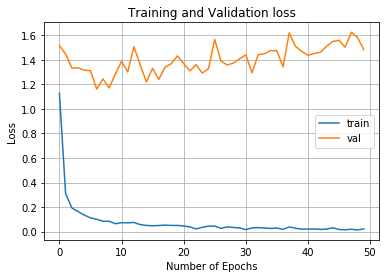

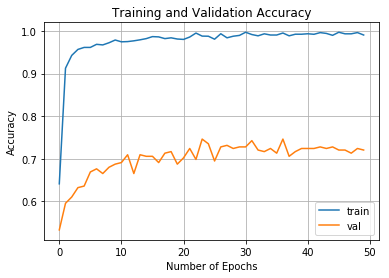

In [11]:
plotter(xc, train_loss, val_loss, 'Loss', 'Training and Validation loss')
plotter(xc, train_acc, val_acc, 'Accuracy', 'Training and Validation Accuracy')

**The final validation accuracy is 72.06%!** But let's analyze the training curves with more detail.

Note that in the first figure (Train and Validation loss) the train loss decreases almost to 0. However, this is not the case for the validation loss. This might be an indicator that the model is overfitting the dataset; the model has way too many parameters and therefore is able to completely memorize the labeled samples so as to achieve high accuracy, instead of learning those few but critical features required to identify new samples.

Overfitting is one of the major issues that DNNs face, and there are several mechanisms to address it: regularization and dropout. Batch normalization may also aliviate the problem depite not being its main porpuse, and more recently introduced techniques like pruning also help if applied properly**.

Naturally, changing the DNN size or its architecture is always an option. In this case, let us try to reduce the size of the model by replacing those highly overparametrized FC layers for slighly smaller ones. Those last 3 FC layers that we will replace must be fine-tuned, since we are creating them from scratch.

** Properly applying pruning is an open research issue

### Finetunning

We now ignore the 3 FC layers from the original VGG16 model, and grab the max pooling layer (dimensions 7x7x512) that follows the last convolution block to use it a input to a new fully connected classifier.

In [13]:
last_layer = model.get_layer('block5_pool').output

x= Flatten(name='flatten')(last_layer) # flatten the output of the pooling layer and pass it to the next FC layer
x = Dense(512, activation='relu', name='fc1')(x) # fc1
x = Dense(512, activation='relu', name='fc2')(x) # fc2
out = Dense(units=10, activation='softmax', name='output')(x) # softamx output

custom_model2 = Model(placeholder, out)

for layer in custom_model2.layers[:-3]:# freeze all parameters except those belonging to the FC layers
    layer.trainable = False

custom_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
custom_model2.summary() # print a summary of the model 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Looking at the summary we just printed, we observe that the total number of parameters has been reduced from 130 millions (our model with overfitting) to about 28 millions. Next, we fine-tune the new layers for 50 epochs.

In [14]:
t = time.time()
# train the model
hist = custom_model2.fit_generator(
    generator = train_data,
    steps_per_epoch = steps_per_epoch,
    epochs = number_epochs,
    validation_data = val_data,
    validation_steps = validation_steps )
print('-'*40)
print('Training time: %s min' % ( (time.time()-t)/60 ))

Epoch 1/50
34/34 [==============================] - 11s 317ms/step - loss: 13.5729 - acc: 0.1504 - val_loss: 13.3185 - val_acc: 0.1581
Epoch 2/50
34/34 [==============================] - 10s 297ms/step - loss: 12.5859 - acc: 0.2115 - val_loss: 13.5076 - val_acc: 0.1581
Epoch 3/50
34/34 [==============================] - 10s 307ms/step - loss: 11.7271 - acc: 0.2638 - val_loss: 12.2170 - val_acc: 0.2316
Epoch 4/50
34/34 [==============================] - 10s 296ms/step - loss: 11.1889 - acc: 0.2949 - val_loss: 11.5105 - val_acc: 0.2574
Epoch 5/50
34/34 [==============================] - 10s 306ms/step - loss: 9.4117 - acc: 0.3912 - val_loss: 9.2698 - val_acc: 0.3934
Epoch 6/50
34/34 [==============================] - 10s 305ms/step - loss: 8.1337 - acc: 0.4680 - val_loss: 9.9075 - val_acc: 0.3566
Epoch 7/50
34/34 [==============================] - 10s 305ms/step - loss: 7.9463 - acc: 0.4864 - val_loss: 9.8410 - val_acc: 0.3529
Epoch 8/50
34/34 [==============================] - 11s 310ms

In [15]:
# extract the records of the training process for visualization
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']

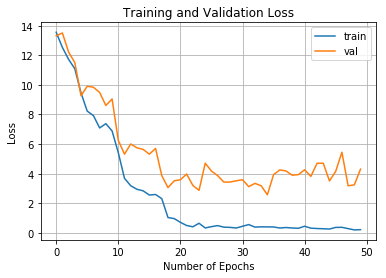

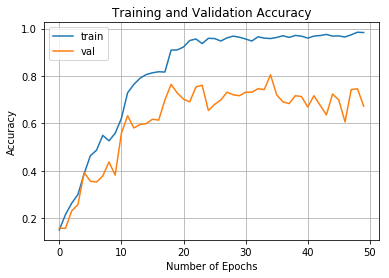

In [16]:
plotter(xc, train_loss, val_loss, 'Loss', 'Training and Validation Loss')
plotter(xc, train_acc, val_acc, 'Accuracy', 'Training and Validation Accuracy')

Now we observe that both the Training and Validation loss decrease as the training progresses. Unfortunately, validation accuracy is lower than what we obtained in our first attempt, by about 5%.
Lets save the model and observe if we can get better results by prolonging the training process for few more epochs. 

In [18]:
model_name = 'costum_model2'
save_dir = '../models/' + model_name + '.h5'
custom_model2.save_weights(save_dir) # save the model as h5 file
#costum_model.load_weights(save_dir)

In [19]:
# resume the training, now for only 5 epochs
t = time.time()
extra_epochs = 5

hist2 = custom_model2.fit_generator(
    generator = train_data,
    steps_per_epoch = steps_per_epoch,
    epochs = extra_epochs,
    validation_data = val_data,
    validation_steps = validation_steps )
print('-'*40)
print('Training time: %s min' % ( (time.time()-t)/60 ))

Epoch 1/5
34/34 [==============================] - 11s 312ms/step - loss: 0.2933 - acc: 0.9733 - val_loss: 3.3766 - val_acc: 0.7353
Epoch 2/5
34/34 [==============================] - 10s 308ms/step - loss: 0.2636 - acc: 0.9766 - val_loss: 4.2833 - val_acc: 0.6838
Epoch 3/5
34/34 [==============================] - 10s 306ms/step - loss: 0.3122 - acc: 0.9738 - val_loss: 4.2271 - val_acc: 0.6875
Epoch 4/5
34/34 [==============================] - 11s 311ms/step - loss: 0.2302 - acc: 0.9770 - val_loss: 3.5845 - val_acc: 0.7279
Epoch 5/5
34/34 [==============================] - 10s 301ms/step - loss: 0.2076 - acc: 0.9761 - val_loss: 3.7304 - val_acc: 0.7206
----------------------------------------
Training time: 0.873801000913 min


In [20]:
train_loss2 = train_loss + hist2.history['loss']
val_loss2 = val_loss + hist2.history['val_loss']
train_acc2 = train_acc + hist2.history['acc']
val_acc2 = val_acc + hist2.history['val_acc']
xc=range(number_epochs + extra_epochs)

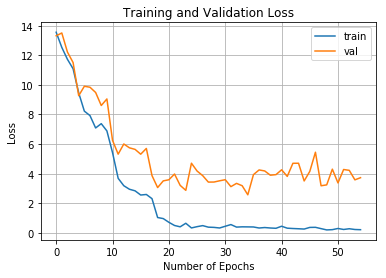

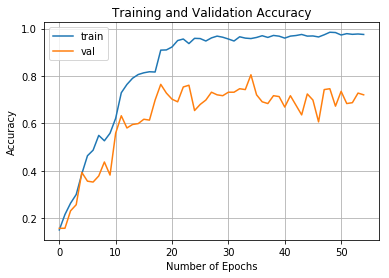

In [21]:
plotter(xc, train_loss2, val_loss2, 'Loss', 'Training and Validation Loss')
plotter(xc, train_acc2, val_acc2, 'Accuracy', 'Training and Validation Accuracy')

In [22]:
# run a accuracy evaluation on the validation set and  print the resulting accuracy
custom_model2.evaluate_generator(val_data, validation_steps)

[3.7304116627749275, 0.72058823529411764]

By prolonging the training we manage to match the accuracy if the first model, 72.058% according to the output of the "evaluate_generator()" function call. Additinally, the validation loss is now closer to the train loss. Since the validation dataset is so small, we might not be able to measure an improvement in the validation accuracy. However, we can expect that if the the second model would perform better in never before seen samples since it overfitts less the trainig dataset.

It might be worth looking more closely at what samples are preventing the model from achieving a higher validation accuracy. In the next section we build a confusion matrix that will help our analysis.

 ## Class by class accuracy analysis

One way create a confusion matrix is by utilizing the scikit-learn library. Before, we were let Keras load the data batches upon request of the training method. Now we need to manually forward the data so as to calculate the matrix. Therefore, we must load the validation images, convert them to np arrays and stack them in a tensor of the proper dimensions

The following cell does exactly that; it builds a tensor with the converted data, X is images, Y is labels.

In [23]:
batches = 1
DEBUG = False

for x_batch, y_batch in val_data:# read the data from disk using the same data generator as before
    
    # Build X_test and Y_test tensors by concatenatining the batches
    if batches == 1:
        X_test = np.copy(x_batch)
        Y_test = np.copy(y_batch)
    else:
        X_test = np.concatenate((X_test, x_batch), axis=0)
        Y_test = np.concatenate((Y_test, y_batch), axis=0)
        
    if DEBUG:
        print("--- Batch #: {0} ---".format(batches))
        print("X.shape: {0} , Y.shape: {1}".format(X_test.shape, Y_test.shape))
    
    
    if batches >= validation_steps:
        break # we need to break the loop by hand because
              # the data generator loops indefinitely  otherwise
    batches += 1

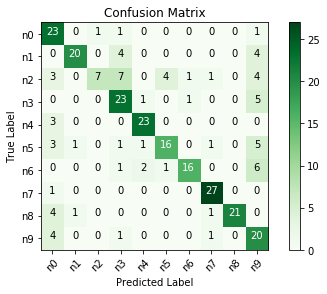

In [36]:
# Printing the confusion matrix
from sklearn.metrics import classification_report,confusion_matrix

Y_pred = custom_model2.predict(X_test) # forward the validation set to generate predictions
Y_pred_idxs = np.argmax(Y_pred, axis=1) # and extract the index number of the must probable class in each case

target_names = ['n' + str(i) for i in range(10)] # simplified labels are n0~n9

# Compute confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(Y_test,axis=1), Y_pred_idxs))

#np.set_printoptions(precision=2)
confusion_matrix_plotter(cnf_matrix, classes=target_names)

# We can adiationally print out a report on the classification stats (recall, f1-score...) 
# by uncommenting the following line:
# print(classification_report(np.argmax(Y_test,axis=1), Y_pred_idxs,target_names=target_names))

Auxiliary operation: Save the model for later use...

In [37]:
model_name = 'costum_model2'
save_dir = '../models/' + model_name + '.h5'
custom_model2.save_weights(save_dir)
#costum_model.load_weights(save_dir)

Looking at the confusion matrix we observe n2 has the lowest accuracy of all classes. Just for curiosity, lets look a  random sample of this class

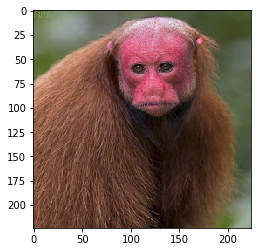

In [43]:
LABEL = 'n2'
IMAGE = 'n2013.jpg'
img = load_img(VAL_DIR+'/'+LABEL+'/'+IMAGE, target_size =(img_width, img_height)) # image loaded as PIL object
_ = plt.imshow(img)

Note that must of the errors in the confusion matrix correspond to n2 samples being confused with n3. This is perhaps understandable since n3 corresponds to the Japanese Macaque, with presents similar skin color (red face):

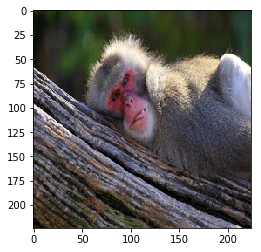

In [50]:
LABEL = 'n3'
IMAGE = 'n3011.jpg'
img = load_img(VAL_DIR+'/'+LABEL+'/'+IMAGE, target_size =(img_width, img_height)) # image loaded as PIL object
_ = plt.imshow(img)

## Conclusion

Despite having such a small size dataset with considerable similarities between classes, we managed to build a image classifier in less than 30 mins, with more that 70% accuracy and with a design aimed at reducing overfitting. 

Further improvements can be made. VGG16 is known for being one of the biggest models out there, and yet has less accuracy than the more recent Residual nets or the inception models. So it might be interesting to see which of those provides the best results, and start tweaking the model until we achieve the desired accuracy.

Needless to say, expanding the dataset would also help.

Hope this was instructive ^^.